In [86]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd

In [2]:
meta_sd = []
with gzip.open("Data/meta-SanDiego.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        meta_sd.append(json.loads(line))

In [3]:
review_sd = []
for i in range(1, 5):
    with gzip.open(f"Data/review-SanDiego_10_file{i}.json.gz", "rt", encoding="utf-8") as f:
        for line in f:
            review_sd.append(json.loads(line))

In [90]:
location_dict = {b['gmap_id']: (b['latitude'],b['longitude']) for b in meta_sd}

In [5]:
review_locations = [location_dict[review_sd[i]['gmap_id']] for i in range(len(review_sd))]

In [62]:
filtered_review_locations = [
    tup for tup in review_locations
    if tup[1] < -116.5
    and tup[0] < 33.8
]

In [63]:
lats = list()
longs = list()
for lat, long in filtered_review_locations:
    lats.append(lat)
    longs.append(long)

In [64]:
max(longs)

-116.5052008

In [65]:
# plt.scatter(lats, longs)

In [66]:
# %pip install contextily pyproj

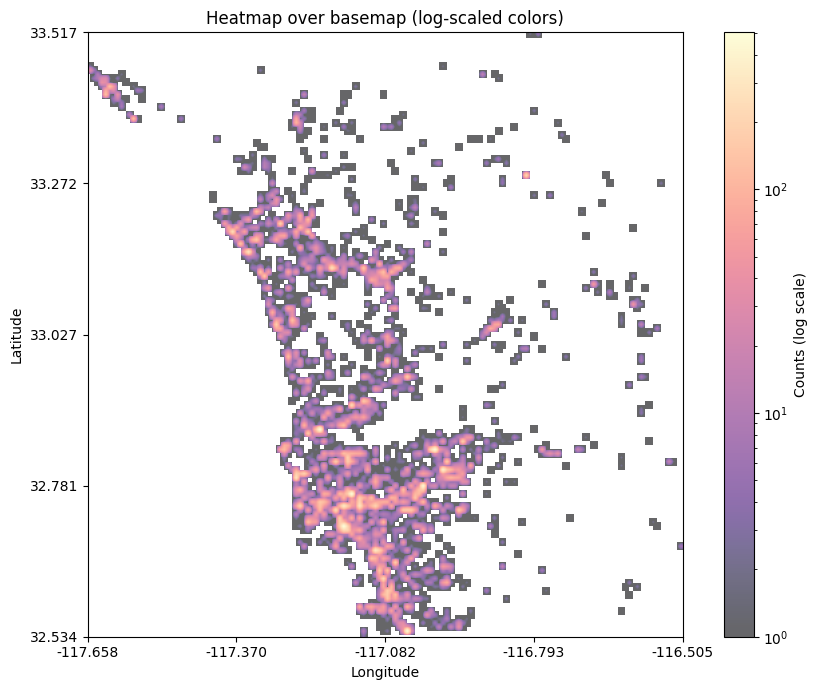

In [89]:
# Fast heatmap over a map background (uses contextily if available)

# prefer longitude as x (map-like)
lon = np.array(longs)
lat = np.array(lats)

# sample for responsiveness
n = len(lon)
if n > 50000:
    idx = np.random.choice(n, size=50000, replace=False)
    lon = lon[idx]; lat = lat[idx]

# try to import contextily/pyproj for basemap tiles
try:
    import contextily as ctx
    from pyproj import Transformer
    has_ctx = True
except Exception as e:
    has_ctx = False

# transform lon/lat (EPSG:4326) to WebMercator (EPSG:3857)
if has_ctx:
    tf = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    mx, my = tf.transform(lon, lat)
else:
    # if no contextily, compute histogram in lon/lat
    mx, my = lon, lat

# compute 2D histogram in the chosen projection
bins = 200 if n <= 50000 else 150
H, xedges, yedges = np.histogram2d(mx, my, bins=bins)

fig, ax = plt.subplots(figsize=(9,7))

# draw basemap if available; try several provider names robustly
if has_ctx:
    zoom = 10
    provider_candidates = [
        'Stamen.TerrainBackground',
        'Stamen.Terrain',
        'Stamen.TonerLite',
        'OpenStreetMap.Mapnik',
        'CartoDB.Positron'
    ]
    img = None
    ext = None
    for pname in provider_candidates:
        # try to get provider by name
        prov = None
        try:
            # ctx.providers behaves like a mapping; prefer .get when available
            if hasattr(ctx.providers, 'get'):
                prov = ctx.providers.get(pname)
            else:
                prov = ctx.providers[pname]
        except Exception:
            prov = None
        if prov is None:
            continue
        try:
            img, ext = ctx.bounds2img(xedges[0], yedges[0], xedges[-1], yedges[-1], zoom=zoom, source=prov)
            used_provider = pname
            break
        except Exception:
            continue
    if img is None:
        # final fallback: try first available provider
        try:
            first_key = list(ctx.providers)[0]
            prov = ctx.providers[first_key]
            img, ext = ctx.bounds2img(xedges[0], yedges[0], xedges[-1], yedges[-1], zoom=zoom, source=prov)
            used_provider = first_key
        except Exception:
            img = None
    if img is not None:
        ax.imshow(img, extent=ext, origin='upper')
        heatmap_extent = ext
    else:
        heatmap_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
else:
    heatmap_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# overlay heatmap with log color scaling and some transparency
nonzero = H[H > 0]
if nonzero.size > 0:
    vmin = max(1, nonzero.min())
else:
    vmin = 1
vmax = max(1, H.max())

ax.imshow(H.T, origin='lower', cmap='magma',
          norm=LogNorm(vmin=vmin, vmax=vmax),
          extent=heatmap_extent,
          alpha=0.6, interpolation='bilinear')

# convert tick labels back to lon/lat if we used WebMercator
if has_ctx:
    inv_tf = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    mean_my = (yedges[0] + yedges[-1]) / 2
    xticks = np.linspace(xedges[0], xedges[-1], 5)
    try:
        xtick_lons, _ = inv_tf.transform(xticks, np.full_like(xticks, mean_my))
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{v:.3f}" for v in xtick_lons])
    except Exception:
        pass

    mean_mx = (xedges[0] + xedges[-1]) / 2
    yticks = np.linspace(yedges[0], yedges[-1], 5)
    try:
        _, ytick_lats = inv_tf.transform(np.full_like(yticks, mean_mx), yticks)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{v:.3f}" for v in ytick_lats])
    except Exception:
        pass

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
else:
    ax.set_xlabel('Longitude or X')
    ax.set_ylabel('Latitude or Y')

cb = plt.colorbar(ax.images[-1], ax=ax, label='Counts (log scale)')
ax.set_title('Heatmap over basemap (log-scaled colors)')
plt.tight_layout()

if not has_ctx:
    print('Note: contextily/pyproj not installed. Run `pip install contextily pyproj` to add a map background.')

In [74]:
# %pip install geopandas

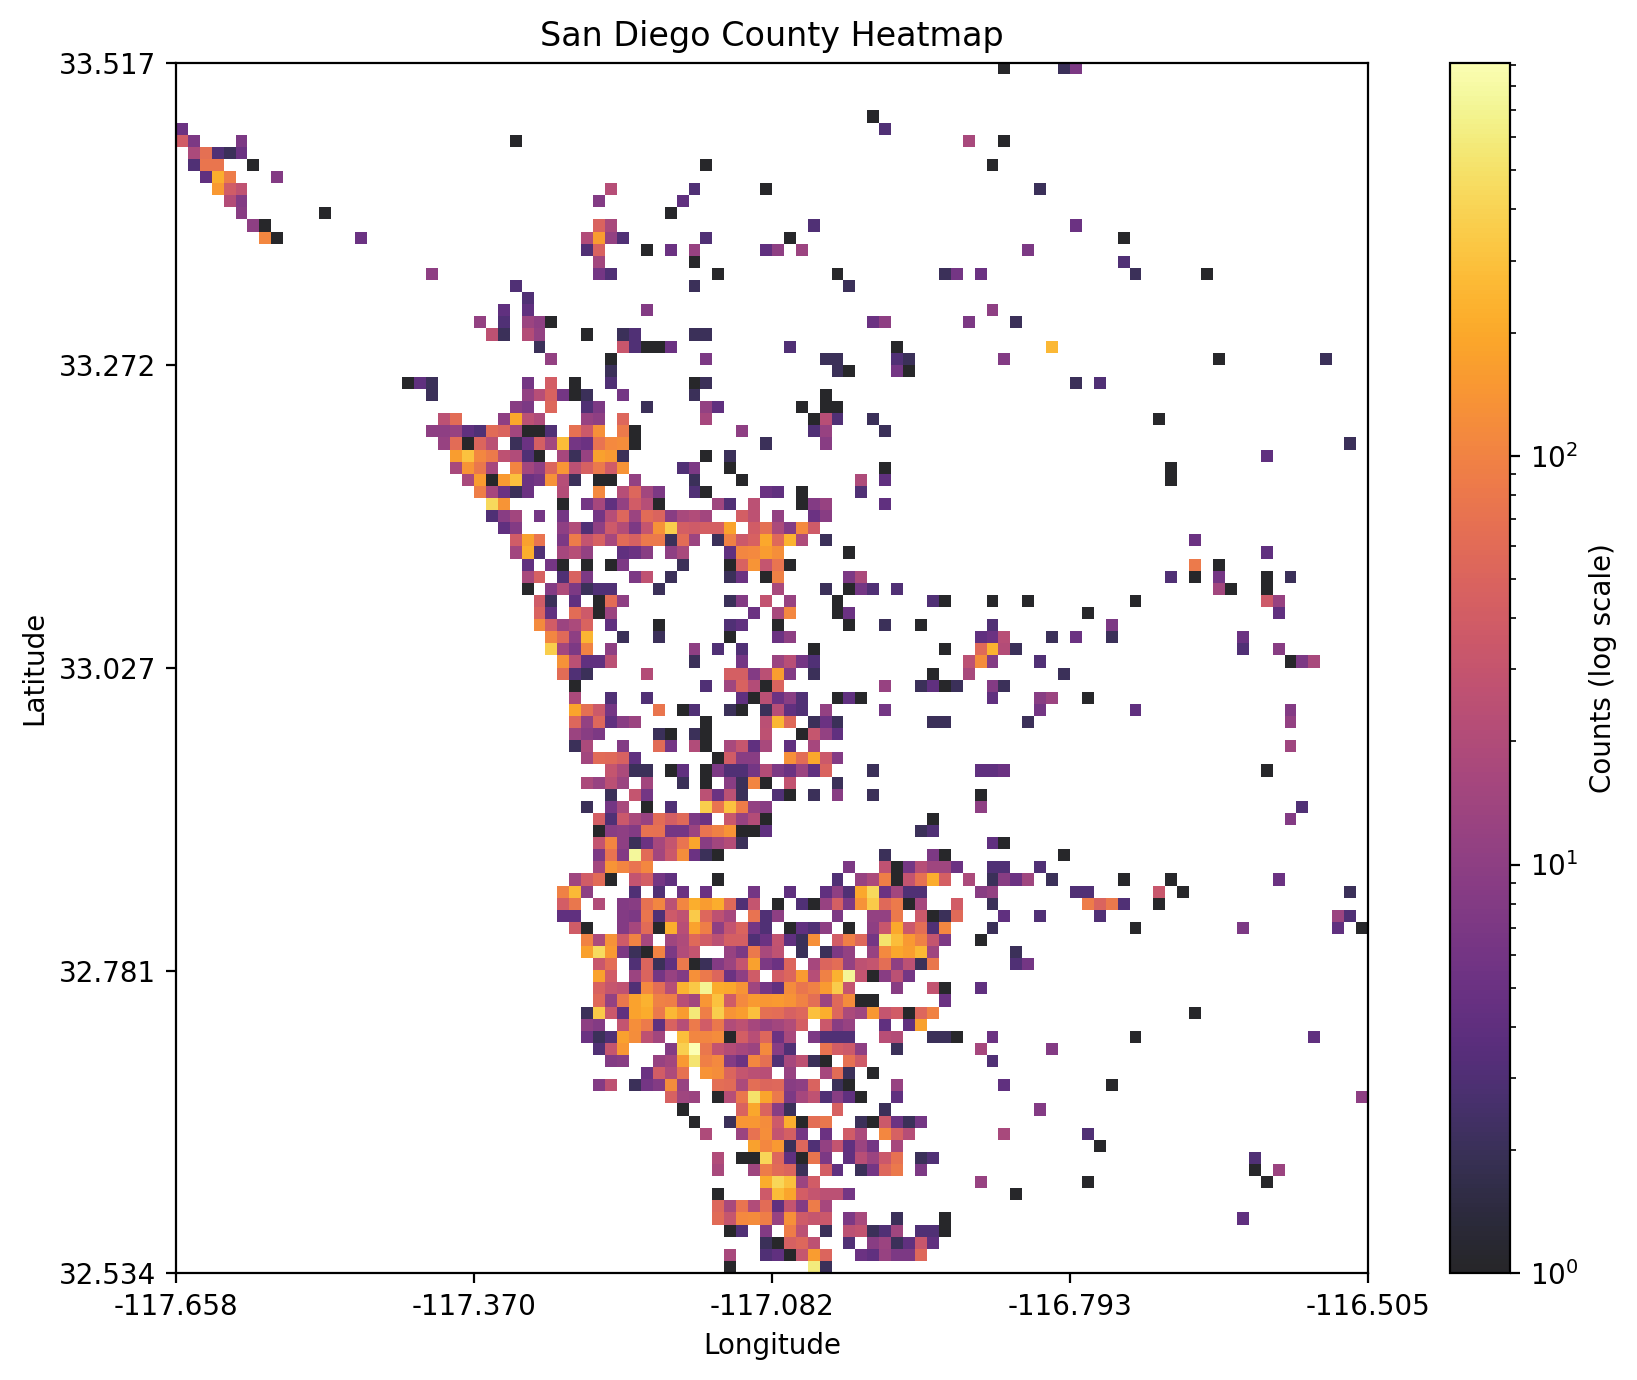

In [88]:
# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
BINS = 100
DPI = 200
ALPHA = 0.85
CMAP = "inferno"

# ---------------------------------------------------------
# 1. CLEAN + FLATTEN lon/lat
# ---------------------------------------------------------
def flatten_numeric(arr):
    arr = np.array(arr, dtype=object).reshape(-1)
    out = []
    for x in arr:
        try:
            if isinstance(x, (float, int, np.floating, np.integer)):
                out.append(float(x))
            elif isinstance(x, (list, tuple, np.ndarray)):
                out.append(float(np.array(x).reshape(-1)[0]))
            else:
                out.append(float(x))
        except:
            continue
    return np.array(out, dtype=float)

lon = flatten_numeric(longs)
lat = flatten_numeric(lats)

m = min(len(lon), len(lat))
lon = lon[:m]
lat = lat[:m]

mask = np.isfinite(lon) & np.isfinite(lat)
lon = lon[mask]
lat = lat[mask]

if len(lon) > 60000:
    idx = np.random.choice(len(lon), 60000, replace=False)
    lon = lon[idx]
    lat = lat[idx]

# ---------------------------------------------------------
# 2. MANUAL WEBMERCATOR PROJECTION
# ---------------------------------------------------------
R = 6378137.0
mx = lon * (R * np.pi/180)

lat_clip = np.clip(lat, -85.05112878, 85.05112878)
my = R * np.log(np.tan(np.pi/4 + np.radians(lat_clip)/2))

mx = mx.reshape(-1)
my = my.reshape(-1)

# ---------------------------------------------------------
# 3. HISTOGRAM
# ---------------------------------------------------------
H, xedges, yedges = np.histogram2d(mx, my, bins=BINS)

# ---------------------------------------------------------
# 4. FIGURE
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(9,7), dpi=DPI)

# ---------------------------------------------------------
# 5. LOAD SAN DIEGO COUNTY SHAPEFILE / GEOJSON
# ---------------------------------------------------------
# IMPORTANT: change this path to your file if needed
# gdf = gpd.read_file("Data/san_diego_boundary_datasd.geojson")

# # Convert lat/lon → WebMercator manually
# def mercator_x(lon):
#     return lon * (R * np.pi/180)

# def mercator_y(lat):
#     lat = np.clip(lat, -85.05112878, 85.05112878)
#     return R * np.log(np.tan(np.pi/4 + np.radians(lat)/2))

# # Project all county polygons manually
# gdf["merc"] = gdf["geometry"].apply(
#     lambda geom: 
#         type(geom)(
#             [(mercator_x(x), mercator_y(y)) for x, y in geom.exterior.coords]
#         )
# )

# # Plot county outline
# for poly in gdf["merc"]:
#     ax.plot(
#         *poly.exterior.xy,
#         color="white",
#         linewidth=1.5,
#         alpha=0.8
#     )

# ---------------------------------------------------------
# 6. CRISP HEATMAP
# ---------------------------------------------------------
nonzero = H[H > 0]
vmin = max(1, nonzero.min()) if nonzero.size else 1
vmax = max(1, H.max())

ax.imshow(
    H.T,
    origin='lower',
    cmap=CMAP,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    alpha=ALPHA,
    interpolation='nearest'
)

# ---------------------------------------------------------
# 7. INVERSE TICKS (Manual WebMercator)
# ---------------------------------------------------------
def inv_merc_x(x): return x / (R * np.pi/180)
def inv_merc_y(y): return np.degrees(2*np.arctan(np.exp(y/R)) - np.pi/2)

xticks = np.linspace(xedges[0], xedges[-1], 5)
yticks = np.linspace(yedges[0], yedges[-1], 5)

ax.set_xticks(xticks)
ax.set_xticklabels([f"{inv_merc_x(v):.3f}" for v in xticks])

ax.set_yticks(yticks)
ax.set_yticklabels([f"{inv_merc_y(v):.3f}" for v in yticks])

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# ---------------------------------------------------------
# 8. COLORBAR + SHOW
# ---------------------------------------------------------
plt.colorbar(ax.images[-1], ax=ax, label="Counts (log scale)")
ax.set_title("San Diego County Heatmap")
plt.tight_layout()
plt.show()


In [85]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm

# # ---------------------------------------------------------
# # CONFIG (AESTHETICS)
# # ---------------------------------------------------------
# BINS = 120
# FIGSIZE = (11, 9)
# DPI = 200

# HEAT_ALPHA = 0.45        # soft background heat
# DOT_ALPHA = 0.12         # transparency for dots
# CMAP_HEAT = "inferno"    # heatmap underlay
# CMAP_DOTS = "viridis"    # dot color mapping

# DOT_SIZE_MIN = 15
# DOT_SIZE_MAX = 500       # large glowing circles

# # ---------------------------------------------------------
# # 3. HISTOGRAM (for heatmap AND dot density)
# # ---------------------------------------------------------
# H, xedges, yedges = np.histogram2d(mx, my, bins=BINS)

# # ---------------------------------------------------------
# # FIGURE
# # ---------------------------------------------------------
# fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# # ---------------------------------------------------------
# # 4. BACKGROUND HEATMAP
# # ---------------------------------------------------------
# nonzero = H[H > 0]
# vmin = max(1, nonzero.min()) if nonzero.size else 1
# vmax = max(1, H.max())

# ax.imshow(
#     H.T,
#     origin="lower",
#     cmap=CMAP_HEAT,
#     norm=LogNorm(vmin=vmin, vmax=vmax),
#     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
#     alpha=HEAT_ALPHA,
#     interpolation="bilinear"
# )

# # ---------------------------------------------------------
# # 5. DENSITY-WEIGHTED DOTS
# # ---------------------------------------------------------
# # map each point → its histogram bin index
# xbin = np.searchsorted(xedges, mx) - 1
# ybin = np.searchsorted(yedges, my) - 1

# # clip indices
# xbin = np.clip(xbin, 0, H.shape[0] - 1)
# ybin = np.clip(ybin, 0, H.shape[1] - 1)

# # density at each point
# point_density = H[xbin, ybin]

# # normalize density using NumPy 2.0 safe ptp
# dens_min = point_density.min()
# dens_ptp = np.ptp(point_density) + 1e-9   # <-- FIXED HERE

# dens_norm = (point_density - dens_min) / dens_ptp

# # dot sizes & colors
# dot_sizes = DOT_SIZE_MIN + dens_norm * (DOT_SIZE_MAX - DOT_SIZE_MIN)
# dot_colors = dens_norm

# ax.scatter(
#     mx, my,
#     s=dot_sizes,
#     c=dot_colors,
#     cmap=CMAP_DOTS,
#     alpha=DOT_ALPHA,
#     edgecolors="none"
# )

# # ---------------------------------------------------------
# # 6. EXTRA GLOW FOR SUPER-DENSE POINTS
# # ---------------------------------------------------------
# mask_hi = dens_norm > 0.8
# ax.scatter(
#     mx[mask_hi], my[mask_hi],
#     s=dot_sizes[mask_hi] * 2.5,
#     c=dot_colors[mask_hi],
#     cmap=CMAP_DOTS,
#     alpha=0.09,
#     edgecolors="none"
# )

# # ---------------------------------------------------------
# # 7. INVERSE MERCATOR AXES
# # ---------------------------------------------------------
# def inv_merc_x(x): return x / (R * np.pi/180)
# def inv_merc_y(y): return np.degrees(2*np.arctan(np.exp(y/R)) - np.pi/2)

# xticks = np.linspace(xedges[0], xedges[-1], 6)
# yticks = np.linspace(yedges[0], yedges[-1], 6)

# ax.set_xticks(xticks)
# ax.set_xticklabels([f"{inv_merc_x(v):.3f}" for v in xticks])

# ax.set_yticks(yticks)
# ax.set_yticklabels([f"{inv_merc_y(v):.3f}" for v in yticks])

# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")

# ax.set_title("Neon Density Dot Map – San Diego", fontsize=18, weight="bold")
# plt.tight_layout()
# plt.show()
